In [1]:
"""Create parameters.py from a .inp and load it"""
# This cell is facultative, you can use an existing parameters.py

# Directory for .inp file:
path = 'Bubble_dynamics_simulation\\INP file examples\\chem_Otomo2018_without_O.inp'

# import libraries:
import importlib   # for reloading your own files
from termcolor import colored   # for colored error messages
# my own files:
try:
    import inp_data_extractor as inp
except:
    try:
        import Bubble_dynamics_simulation.inp_data_extractor as inp
    except:
        print(colored(f'Error, \'inp_data_extractor.py\' not found', 'red'))
importlib.reload(inp)

# create parameters.py
inp.extract(path)

# load parameters.py
import parameters as par
importlib.reload(par)
print(par.model)

path=Bubble_dynamics_simulation\INP file examples\chem_Otomo2018_without_O.inp
Note, lambda value for specie 'H' is not in data.py: 0.0 is used
Note, lambda value for specie 'NH2' is not in data.py: 0.0 is used
Note, lambda value for specie 'NH' is not in data.py: 0.0 is used
Note, lambda value for specie 'N' is not in data.py: 0.0 is used
Note, lambda value for specie 'NNH' is not in data.py: 0.0 is used
Note, lambda value for specie 'N2H4' is not in data.py: 0.0 is used
Note, lambda value for specie 'N2H3' is not in data.py: 0.0 is used
Note, lambda value for specie 'N2H2' is not in data.py: 0.0 is used
Note, lambda value for specie 'H2NN' is not in data.py: 0.0 is used
Warning, third body 'H2O' is not in species in line 64 (' H2/2.5/ H2O/12/ AR/0.0/ ') in reaction 'H2+M=H+H+M'
Warning, third body 'AR' is not in species in line 64 (' H2/2.5/ H2O/12/ AR/0.0/ ') in reaction 'H2+M=H+H+M'
model: chem_Otomo2018_without_O
File 'parameters.py' succesfully created
chem_Otomo2018_without_O


In [2]:
"""Libraries"""

# for plotting:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

import numpy as np   # matrices, math
import time   # runtime measurement
from multiprocessing import Pool, cpu_count   # multithreading
import importlib   # reload changes you made
import itertools   # assemble all combinations of control parameters
import json   # convert dictionary to string

# my own file:
already_imported = 'de' in globals()
try:
    import full_bubble_model as de
except:
    try:
        import Bubble_dynamics_simulation.full_bubble_model as de
    except:
        print(colored(f'Error, \'full_bubble_model.py\' not found', 'red'))
if already_imported: importlib.reload(de)   # reload changes you made

model: chem_Otomo2018_without_O
target specie: NH3
excitation: sin_impulse (control parameters: ['p_A', 'freq', 'n'])
enable heat transfer: True	enable evaporation: False	enable reactions: True	enable dissipated energy: True


In [16]:
"""Control parameter ranges and division"""
# a list for each control parameter, containing all the possible values

ranges = dict(
  # Initial conditions:
    # bubble equilibrium radius [m]
    R_E = [1e-6*x for x in [60, 70, 80, 90, 100, 110, 120, 130, 140, 150]], # [um --> m]
    # initial radius / equilibrium radius R_0/R_E [-]
    ratio = [1.0],
  # Ambient parameters:
    # ambient pressure [Pa]
    P_amb = [x * par.atm2Pa for x in [1.0]], # [atm --> Pa]
    # ambient temperature [K]       
    T_inf = [par.absolute_zero + x for x in [30.0]], # [°C --> K]
  # Liquid parameters:
    # water accommodation coefficient [-]
    alfa_M = [0.35],
    #P_v = par.P_v,                    # vapour pressure [Pa]
    #mu_L = par.mu_L,                  # dynamic viscosity [Pa*s]
    # sound speed [m/s]
    c_L = [par.c_L],
    # surfactant (surface tension modfier) [-]
    surfactant = [1.0],
  # Excitation parameters: (excitation_type = no_excitation)
    p_A = [-1e5*x for x in [1.5, 1.625, 1.750, 1.875, 2.0]], # [bar --> Pa]
    freq = [1e3*x for x in [10.0, 15.0]], # [Hz]
    n = [1.0], # [-]
    
)

for key in de.excitation_args:
    if key not in ranges:
        print(colored(f'Error, {key} not in ranges', 'red'))
# print total combinations:
for key in ranges:
    print(f'{key}: {len(ranges[key])}')
total_combinations = f'total combinations: {np.prod([len(ranges[key]) for key in ranges])}'
print(''.join(['_' for i in range(len(total_combinations))]))
print(total_combinations)

R_E: 10
ratio: 1
P_amb: 1
T_inf: 1
alfa_M: 1
c_L: 1
surfactant: 1
p_A: 5
freq: 2
n: 1
_______________________
total combinations: 100


In [17]:
"""Get all combinations"""
# Make a list, with one dictionary for eachy parameter combinations

start = time.time()
cpars = []
ID = 1
for values in itertools.product(*ranges.values()):
    cpar = dict(zip(ranges.keys(), values))
    cpar['ID'] = ID                      # ID of control parameter (not used during calculation)
    cpar['gases'] = [par.index['H2'], par.index['N2']]    # indexes of species in initial bubble (list of species indexes)
    cpar['fractions'] = [0.75, 0.25]            # molar fractions of species in initial bubble (list of fractions for every gas)
    # Calculate pressure/temperature dependent parameters:
    cpar['mu_L'] = de.Viscosity(cpar['T_inf'])
    cpar['P_v'] = de.VapourPressure(cpar['T_inf'])
    cpars.append(cpar)
    ID += 1

print(f'Assemble cpars: {time.time()-start:.2f} s')
start = time.time()

# Create input dictionary for de.simulate(), a list of dictionaries with cpar and other arguments
kwargs_list = [dict(cpar=cpar, t_int=np.array([0.0, 1.0]), LSODA_timeout=200, Radau_timeout=0) for cpar in cpars]
end = time.time()
print(f'Assemble kwargs_list: {time.time()-start:.2f} s')

Assemble cpars: 0.00 s
Assemble kwargs_list: 0.00 s


In [5]:
"""Parameter study, multithread"""

good = []
bad = []
best_energy_efficiency = 1e30

start = time.time()
with Pool(processes=cpu_count(), maxtasksperchild=100) as pool:
    results = pool.imap_unordered(de.simulate, kwargs_list)

    for data in results:
      # save results:
      data = de.dotdict(data)
      if data.success == True:
        good.append(data)
      else:
        bad.append(data)
      # print stuff:
      if data.energy_efficiency > 0 and data.energy_efficiency < best_energy_efficiency:
          best_energy_efficiency = data.energy_efficiency
      excitation_params = ''.join([f'{key}={data[key]: <12}; ' for key in de.excitation_args])
      print(f'index: {data.ID: >8}/{len(cpars)};   error_code: {data.error_code: >4};   steps: {data.steps: <8};   runtime: {data.elapsed_time: 6.2f} [s]   |   '+
            f'R_E={1e6*data.R_E: 6.2f} [um];  {excitation_params}   |   ' +
            f'{de.target_specie} production: {data.energy_efficiency: e} [MJ/kg] (best: {best_energy_efficiency: .1f} [MJ/kg])'+
            '                                                 ', end='\r')
              
end = time.time()
elapsed = end - start
print(f'\n\nDONE')
print(f'total time: {(elapsed / 3600): .0f} hours {((elapsed % 3600) / 60): .0f} mins')
print(f'            {elapsed: .2f} [s]   ({(elapsed / len(    cpars)): .2f} [s/run])')

index:       99/100;   error_code:    0;   steps: 16431   ;   runtime:  65.38 [s]   |   R_E= 150.00 [um];  p_A=-200000.0   ; freq=10000.0     ; n=1.0         ;    |   NH3 production:  3.042640e+03 [MJ/kg] (best:  883.7 [MJ/kg])                                                 

DONE
total time:  0 hours  8 mins
             475.27 [s]   ( 4.75 [s/run])


In [18]:
"""Parameter study, multithread"""

good = []
bad = []
best_energy_efficiency = 1e30

start = time.time()
for kwargs in kwargs_list:
    data = de.simulate(kwargs)

    # save results:
    data = de.dotdict(data)
    if data.success == True:
      good.append(data)
    else:
      bad.append(data)
      # print stuff:
    if data.energy_efficiency > 0 and data.energy_efficiency < best_energy_efficiency:
          best_energy_efficiency = data.energy_efficiency
    excitation_params = ''.join([f'{key}={data[key]: <12}; ' for key in de.excitation_args])
    print(f'index: {data.ID: >8}/{len(cpars)};   error_code: {data.error_code: >4};   steps: {data.steps: <8};   runtime: {data.elapsed_time: 6.2f} [s]   |   '+
            f'R_E={1e6*data.R_E: 6.2f} [um];  {excitation_params}   |   ' +
            f'{de.target_specie} production: {data.energy_efficiency: e} [MJ/kg] (best: {best_energy_efficiency: .1f} [MJ/kg])'+
            '                                                 ', end='\r')
              
end = time.time()
elapsed = end - start
print(f'\n\nDONE')
print(f'total time: {(elapsed / 3600): .0f} hours {((elapsed % 3600) / 60): .0f} mins')
print(f'            {elapsed: .2f} [s]   ({(elapsed / len(    cpars)): .2f} [s/run])')

C:\Users\aron\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\integrate\_ode.py:1348: UserWarning: lsoda: Repeated convergence failures (perhaps bad Jacobian or tolerances).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


index:      100/100;   error_code:    0;   steps: 15920   ;   runtime:  42.57 [s]   |   R_E= 150.00 [um];  p_A=-200000.0   ; freq=15000.0     ; n=1.0         ;    |   NH3 production:  3.523960e+07 [MJ/kg] (best:  883.7 [MJ/kg])                                                 

DONE
total time:  1 hours  0 mins
             3628.02 [s]   ( 36.28 [s/run])


In [19]:
runtimes = [data['elapsed_time'] for data in good]
steps = [data['steps'] for data in good]
print(f'steps: {np.mean(steps): .0f}')
print(f'elapsed_time: {elapsed: .2f} [s];  avarege: {(np.mean(runtimes)): .3f} [s/run]')
print(f'good: {len(good)} [%]')
codes = [data["error_code"]%10 for data in bad]
print(f'solver/timeout/fatal [%]: {len([x for x in codes if x == 1])};  ', end='')
print(f'{len([x for x in codes if x == 2])};  ', end='')
print(f'{len([x for x in codes if x == 3])}')

steps:  13502
elapsed_time:  3628.02 [s];  avarege:  34.648 [s/run]
good: 97 [%]
solver/timeout/fatal [%]: 2;  1;  0


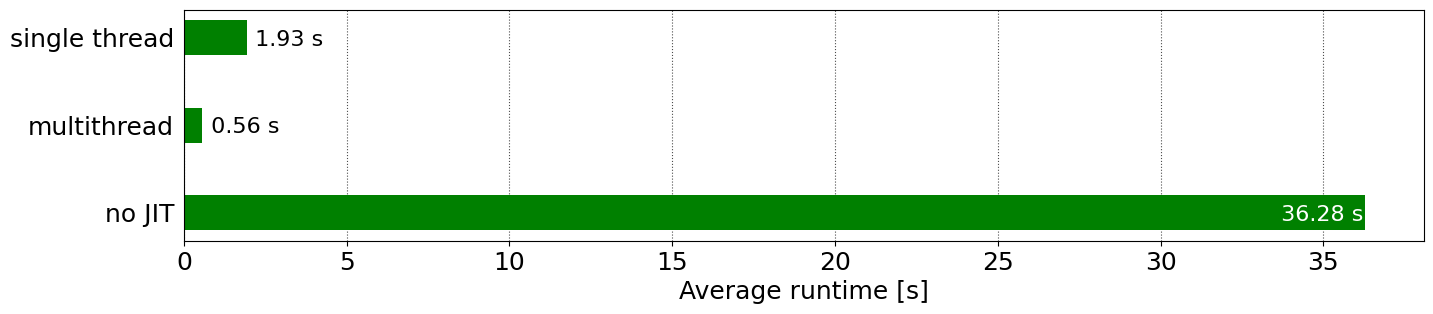

In [3]:
solver =  ['single thread', 'multithread', 'no JIT',]
runtime = [1.925,   0.556,   36.28,    ]


plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(16, 3))
ax = fig.add_subplot(axisbelow=True)
ax.barh(solver, runtime, height=0.4, label='Runtime [s]', color='green')

ax.grid(color='k', axis='x', linestyle=':', alpha=0.7, zorder=0)
ax.invert_yaxis()
ax.set_xlabel('Average runtime [s]')
ax.yaxis.set_ticks_position('none')

# add data labels
for i, bar in enumerate(ax.patches):
    if i == 2:
        ax.text(bar.get_width()-0.05, bar.get_y()+0.22, f'{bar.get_width(): .2f} s',
                fontsize = 16, fontweight ='normal', verticalalignment='center', horizontalalignment='right',
                color ='white')
    else:
         ax.text(bar.get_width()+0.05, bar.get_y()+0.22, f'{bar.get_width(): .2f} s',
                fontsize = 16, fontweight ='normal', verticalalignment='center', horizontalalignment='left',
                color ='black')
         
fig.savefig(r"D:\BME_OneDrive\BME-7\Szakdolgozat\runtime_opt.svg", bbox_inches='tight')

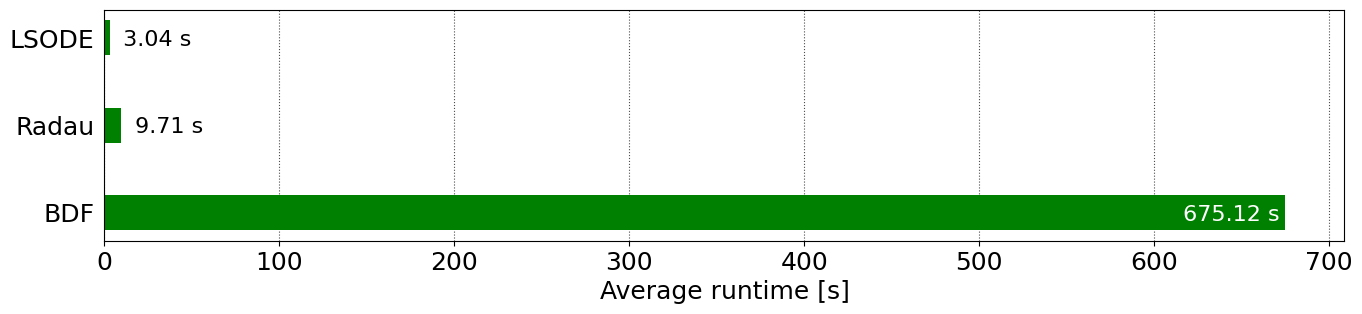

In [25]:
solver =  ['LSODE', 'Radau', 'BDF',     ]
runtime = [3.042,   9.705,   675.12,    ]
fails =   [8.0,     34.0,    0.0,       ]
steps =   [13530,   11214,   70958,     ]

plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(16, 3))
ax = fig.add_subplot(axisbelow=True)
ax.barh(solver, runtime, height=0.4, label='Runtime [s]', color='green')

ax.grid(color='k', axis='x', linestyle=':', alpha=0.7, zorder=0)
ax.invert_yaxis()
ax.set_xlabel('Average runtime [s]')
ax.yaxis.set_ticks_position('none')

# add data labels
for i, bar in enumerate(ax.patches):
    if i == 2:
        ax.text(bar.get_width()-3.5, bar.get_y()+0.22, f'{bar.get_width(): .2f} s',
                fontsize = 16, fontweight ='normal', verticalalignment='center', horizontalalignment='right',
                color ='white')
    else:
         ax.text(bar.get_width()+3.5, bar.get_y()+0.22, f'{bar.get_width(): .2f} s',
                fontsize = 16, fontweight ='normal', verticalalignment='center', horizontalalignment='left',
                color ='black')
         
fig.savefig(r"D:\BME_OneDrive\BME-7\Szakdolgozat\runtime_solvers.svg", bbox_inches='tight')